# Logistic Regression Custom Implementation - Abdullah Chaudhry

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline

mainfile = pd.read_csv("processedFile.csv")
mainfile.head()

,Unnamed: 0,title,stars,reviews,price,listPrice,category,isBestSeller,boughtInLastMonth
0,0,"Sion Softside Expandable Roller Luggage, Black...",4.5,0,139.99,0.00,Suitcases,False,2000
1,1,Luggage Sets Expandable PC+ABS Durable Suitcas...,4.5,0,169.99,209.99,Suitcases,False,1000
2,2,Platinum Elite Softside Expandable Checked Lug...,4.6,0,365.49,429.99,Suitcases,False,300
3,3,Freeform Hardside Expandable with Double Spinn...,4.6,0,291.59,354.37,Suitcases,False,400
4,4,Winfield 2 Hardside Expandable Luggage with Sp...,4.5,0,174.99,309.99,Suitcases,False,400


In [40]:
amazCols = ['stars', 'reviews', 'price', 'listPrice', 'boughtInLastMonth', 'isBestSeller']
XCols = ['stars', 'reviews', 'price', 'listPrice', 'boughtInLastMonth']

data = mainfile[amazCols]
print(data['isBestSeller'].value_counts())
print("\n")

# Undersample data (class imbalance)
data_false = data[data.isBestSeller == False]
data_true = data[data.isBestSeller == True]

print("Initial Data")
print("Data False:", data_false.index.size)
print("Data True:", data_true.index.size)
print("\n")

if(data_false.index.size < data_true.index.size):
    data_min = data_false
    data_maj = data_true
else:
    data_min = data_true
    data_maj = data_false
    
# print(data_min.index.size)
# print(data_maj.index.size)
# print("\n")

data_maj_adjusted = data_maj.sample(data_min.index.size)

print("Downsampled Data")

data = pd.concat([data_maj_adjusted, data_min])
print(data['isBestSeller'].value_counts())

isBestSeller
False    1417817
True        8520
Name: count, dtype: int64


Initial Data
Data False: 1417817
Data True: 8520


Downsampled Data
isBestSeller
False    8520
True     8520
Name: count, dtype: int64


In [41]:
# Split into training and testing data sets
# print(data['isBestSeller'].value_counts())
X = data[XCols]
Y = data.isBestSeller

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.75, random_state=1234)
# print((type(X_train)))

In [42]:
def sig(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegression():

    def __init__(self, lr = 0.01, its = 1000):
        self.lr = lr
        self.its = its
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        samples, features = X.shape
        self.weights = np.zeros(features)
        self.bias = 0

        for _ in range(self.its):
            par = np.dot(X, self.weights) + self.bias
            initPreds = sig(par)

            gradWeight = (1 / samples) * np.dot(X.T, (initPreds - y))
            gradBias = (1 / samples) * np.sum(initPreds - y)

            self.weights = self.weights - self.lr * gradWeight
            self.bias = self.bias - self.lr * gradBias


    def predict(self, X):
        par = np.dot(X, self.weights) + self.bias
        YPred = sig(par)
        class_pred = [0 if y <= 0.5 else 1 for y in YPred]
        return class_pred
    
    # Unused (based on sklearn implementation)
    def score(self, y_test, YPred):
        u = ((y_test - YPred) ** 2).sum()
        v = ((y_test - y_test.mean()) ** 2).sum()
        return (1 - (u / v))

Text(0.5, 1.0, 'All Features')

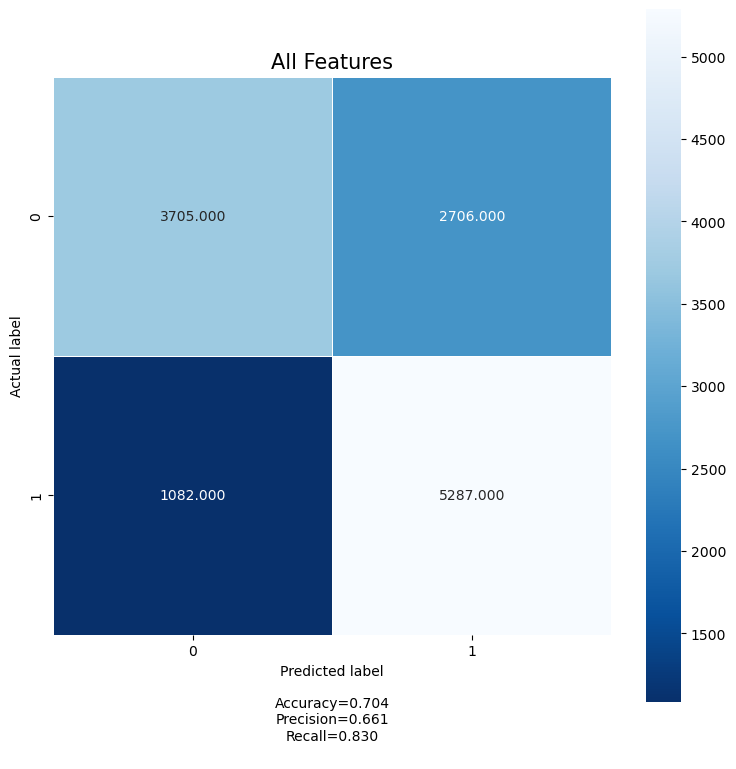

In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

confusionMatrix = metrics.confusion_matrix(Y_test, Y_pred)

# Code for confusion matrix adapted from https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
# Code  for stats text adapted from https://github.com/DTrimarchi10/confusion_matrix?source=post_page-----fc31e3f30fea--------------------------------
plt.figure(figsize=(9,9))
sns.heatmap(confusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
plt.xlabel('Predicted label' + stats_text)
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
all_sample_title = 'All Features'
plt.title(all_sample_title, size = 15)

In [44]:
# https://medium.com/@avijit.bhattacharjee1996/implementing-k-fold-cross-validation-from-scratch-in-python-ae413b41c80d
def kfoldIndices(data, k):
    size = len(data) // k
    indices = np.arange(len(data))
    folds = []
    for i in range(k):
        testIndices = indices[i * size: (i + 1) * size]
        trainIndices = np.concatenate([indices[:i * size], indices[(i + 1) * size:]])
        folds.append((trainIndices, testIndices))
    return folds

k = 5
foldI = kfoldIndices(X, k)

# print(fold_indices[0])

scores = []

for trainI, testI in foldI:
    X_train, y_train = X.iloc[trainI], Y.iloc[trainI]
    X_test, y_test = X.iloc[testI], Y.iloc[testI]
    
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    fold_score = metrics.accuracy_score(y_test, y_pred)
    prec_score = metrics.precision_score(y_test, y_pred)
    
    scores.append(fold_score)
    
mean_accuracy = np.mean(scores)
print("Raw Scores:", scores)
print("Mean:", mean_accuracy)

Raw Scores: [0.8034037558685446, 0.5434272300469484, 0.7455985915492958, 0.7767018779342723, 0.11384976525821597]
Mean: 0.5965962441314554


In [45]:
X = data[['stars']]

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
logreg.fit(X_train, Y_train)
Y_pred=logreg.predict(X_test)

In [47]:
confusionMatrix = metrics.confusion_matrix(Y_test, Y_pred)

Text(0.5, 1.0, 'Stars')

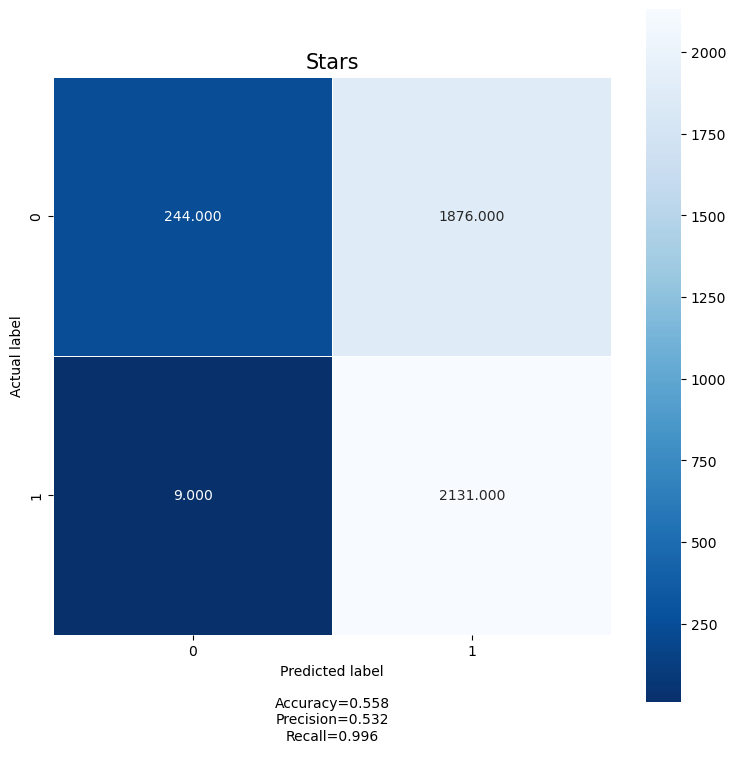

In [48]:
# Stars
plt.figure(figsize=(9,9))
sns.heatmap(confusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
plt.xlabel('Predicted label' + stats_text)
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
all_sample_title = 'Stars'
plt.title(all_sample_title, size = 15)

In [49]:
scores = []

for trainI, testI in foldI:
    X_train, y_train = X.iloc[trainI], Y.iloc[trainI]
    X_test, y_test = X.iloc[testI], Y.iloc[testI]
    
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    fold_score = metrics.accuracy_score(y_test, y_pred)
    
    scores.append(fold_score)
    
mean_accuracy = np.mean(scores)
print("Raw Scores:", scores)
print("Mean:", mean_accuracy)

Raw Scores: [0.08333333333333333, 0.09242957746478873, 0.5492957746478874, 0.0, 0.0]
Mean: 0.1450117370892019


Text(0.5, 1.0, 'Reviews')

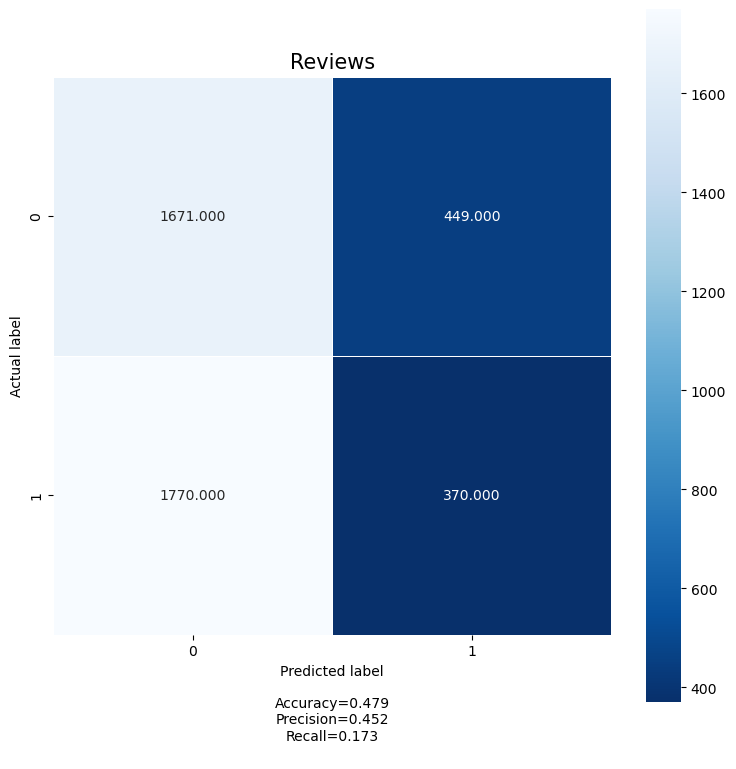

In [50]:
# Reviews
X = data[['reviews']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

logreg.fit(X_train, Y_train)
Y_pred=logreg.predict(X_test)
confusionMatrix = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(confusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
plt.xlabel('Predicted label' + stats_text)
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
all_sample_title = 'Reviews'
plt.title(all_sample_title, size = 15)

In [51]:
scores = []

for trainI, testI in foldI:
    X_train, y_train = X.iloc[trainI], Y.iloc[trainI]
    X_test, y_test = X.iloc[testI], Y.iloc[testI]
    
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    fold_score = metrics.accuracy_score(y_test, y_pred)
    
    scores.append(fold_score)
    
mean_accuracy = np.mean(scores)
print("Raw Scores:", scores)
print("Mean:", mean_accuracy)

Raw Scores: [0.0, 0.0, 0.7362089201877934, 0.0, 0.12147887323943662]
Mean: 0.171537558685446


Text(0.5, 1.0, 'List Price')

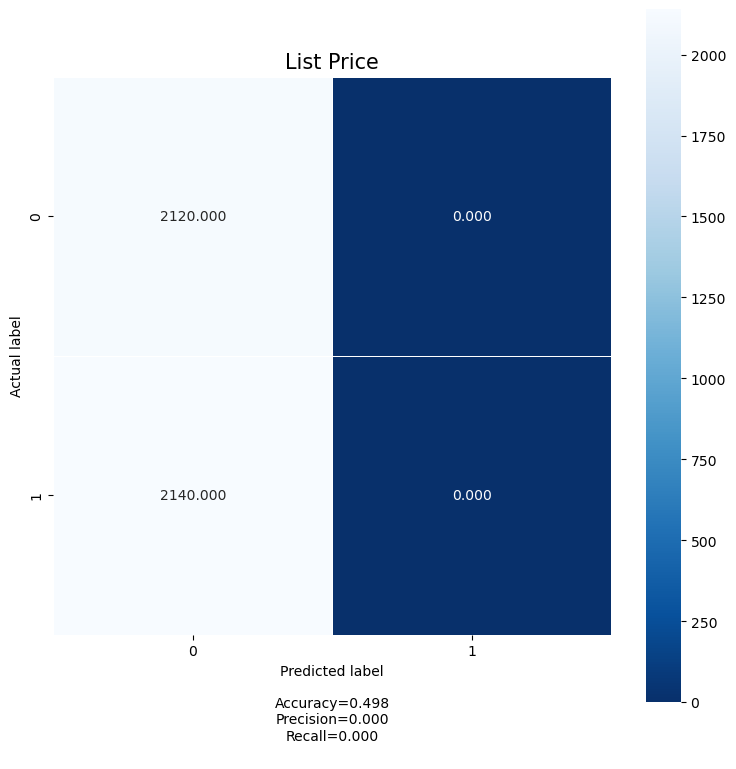

In [52]:
# List Price
X = data[['listPrice']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
logreg.fit(X_train, Y_train)
Y_pred=logreg.predict(X_test)
confusionMatrix = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(confusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
plt.xlabel('Predicted label' + stats_text)
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
all_sample_title = 'List Price'
plt.title(all_sample_title, size = 15)

In [53]:
scores = []

for trainI, testI in foldI:
    X_train, y_train = X.iloc[trainI], Y.iloc[trainI]
    X_test, y_test = X.iloc[testI], Y.iloc[testI]
    
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    fold_score = metrics.accuracy_score(y_test, y_pred)
    
    scores.append(fold_score)
    
mean_accuracy = np.mean(scores)
print("Raw Scores:", scores)
print("Mean:", mean_accuracy)

Raw Scores: [0.011737089201877934, 0.0, 0.5, 0.380575117370892, 0.3274647887323944]
Mean: 0.24395539906103286


Text(0.5, 1.0, 'Bought In Last Month')

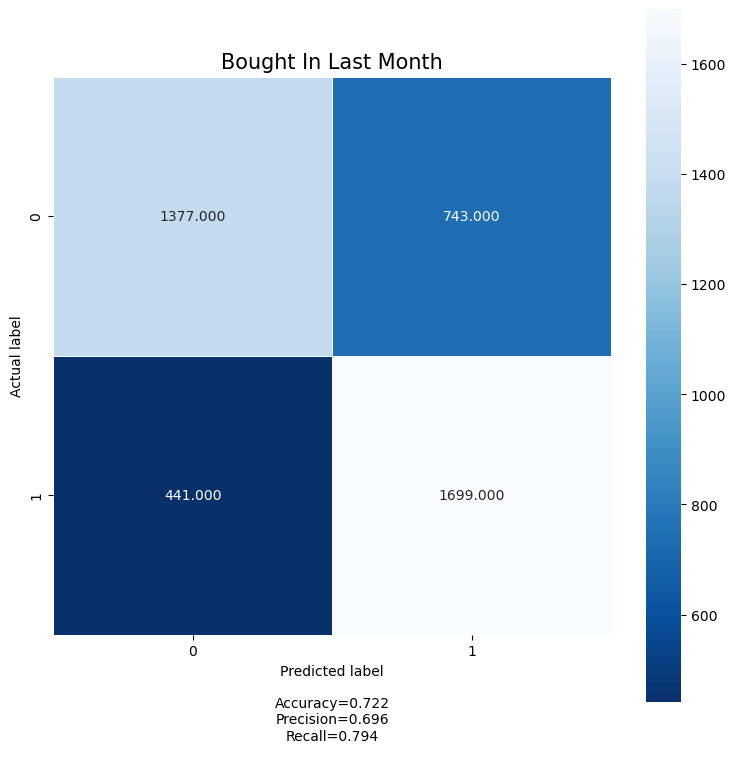

In [54]:
# Bought In Last Month
X = data[['boughtInLastMonth']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
logreg.fit(X_train, Y_train)
Y_pred=logreg.predict(X_test)
confusionMatrix = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(confusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
plt.xlabel('Predicted label' + stats_text)
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
all_sample_title = 'Bought In Last Month'
plt.title(all_sample_title, size = 15)

In [55]:
scores = []

for trainI, testI in foldI:
    X_train, y_train = X.iloc[trainI], Y.iloc[trainI]
    X_test, y_test = X.iloc[testI], Y.iloc[testI]
    
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    fold_score = metrics.accuracy_score(y_test, y_pred)
    
    scores.append(fold_score)
    
mean_accuracy = np.mean(scores)
print("Raw Scores:", scores)
print("Mean:", mean_accuracy)

Raw Scores: [0.6505281690140845, 0.6631455399061033, 0.7065727699530516, 0.8004694835680751, 0.7984154929577465]
Mean: 0.7238262910798122


Text(0.5, 1.0, 'Stars and Reviews')

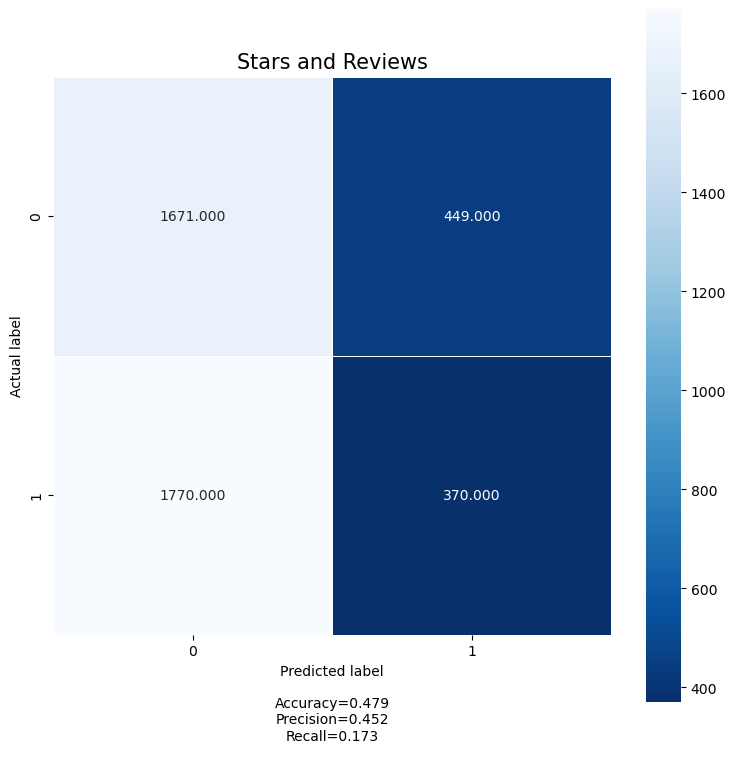

In [56]:
# Stars and Reviews
X = data[['stars', 'reviews']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
logreg.fit(X_train, Y_train)
Y_pred=logreg.predict(X_test)
confusionMatrix = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(confusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
plt.xlabel('Predicted label' + stats_text)
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\n".format(
                metrics.accuracy_score(Y_test, Y_pred),metrics.precision_score(Y_test, Y_pred),metrics.recall_score(Y_test, Y_pred))
all_sample_title = 'Stars and Reviews'
plt.title(all_sample_title, size = 15)

In [57]:
scores = []

for trainI, testI in foldI:
    X_train, y_train = X.iloc[trainI], Y.iloc[trainI]
    X_test, y_test = X.iloc[testI], Y.iloc[testI]
    
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    fold_score = metrics.accuracy_score(y_test, y_pred)
    
    scores.append(fold_score)
    
mean_accuracy = np.mean(scores)
print("Raw Scores:", scores)
print("Mean:", mean_accuracy)

Raw Scores: [0.08656103286384977, 0.09507042253521127, 0.7362089201877934, 0.0, 0.12147887323943662]
Mean: 0.2078638497652582
